In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyswarms as ps

# load data from matlab file mackeyglass time series
loaded_mat = scipy.io.loadmat('MGTimeseries_dde23_tau17.mat')
data_tau17 = loaded_mat['MGseries_dde23_tau17'][0]
data_tau50 = loaded_mat['MGseries_dde23_tau50'][0]

# clean dataset
data = pd.DataFrame({'tau17': data_tau17}) # use tau=17 first
data.index = data.index + 1

In [2]:
# split data set
training_data = data.loc[1:3001]
testing_data = data.loc[3002:]

In [3]:
dummy_data_train = data.loc[1:11]
dummy_data_test = data.loc[12:20]

In [4]:
dummy_data_test

,tau17
12,-0.377937
13,-0.405378
14,-0.430208
15,-0.452674
16,-0.473003
17,-0.491397
18,-0.508040
19,-0.513035
20,-0.493719


In [5]:
N = 10
gamma = 1
s = 1

A = np.random.rand(N,N)
C = np.random.rand(N,1)
zeta = np.random.rand(N,1)

x_0 = np.zeros(shape=(N,1), dtype=float)

def sigma(value):
    return np.tanh(value)

In [6]:
# choose data set used for training
data_train = dummy_data_train
data_test = dummy_data_test

# esn - state equation
def state(x_prev, z_curr):
    z_curr = np.atleast_2d(z_curr)
    x_curr = sigma(np.matmul(A, x_prev) + gamma*np.matmul(C, z_curr) + s*zeta)
    return x_curr

# esn - observation equation
def observation(x_curr, params):
    w = np.array(params[0:N]).reshape(N,1)
    a = params[N]
    z_next = np.matmul(np.transpose(w), x_curr) + a
    return z_next

# output error using parameters on data
def mse(params):
    T = len(data_train)
    error = 0
    x_prev = x_0
    for t in range(1, T):
        z_curr = data_train.loc[t]['tau17']
        x_curr = state(x_prev, z_curr)
        z_next_predict = observation(x_curr, params)[0][0]
        z_next_actual = data_train.loc[t+1]['tau17']
        error = error + (z_next_actual - z_next_predict)**2
        x_prev = x_curr
        
    return error/(T-1)

#### Particle Swarm Optimisation

In [7]:
def swarm_mse(x):
    n_particles = x.shape[0]
    loss_particles = [mse(x[particle]) for particle in range(n_particles)]
    return np.array(loss_particles)

In [8]:
max_bound = np.ones(N+1)
min_bound = np.zeros(N+1)
bounds = (min_bound, max_bound)

options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
dimensions = N+1
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=dimensions, options=options, bounds=bounds)
cost, pos = optimizer.optimize(swarm_mse, iters=20)

2022-01-18 16:08:45,602 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|████████████████████████|20/20, best_cost=10.6
2022-01-18 16:08:45,824 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 10.600670288981643, best pos: [0.97901416 0.34853969 0.19042067 0.43411414 0.04349583 0.11220759
 0.27018933 0.37481411 0.22366188 0.07190196 0.17501316]


In [9]:
w_best = pos[0:N]
a_best = pos[N]

13.573166948073192


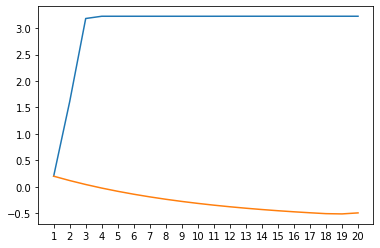

In [10]:
def predict(params):
    z_predictions = [data_train.loc[1]['tau17']]
    z_actuals = [data_train.loc[1]['tau17']]

    T = len(data_train)
    T_bar = len(data_test)
    x_prev = x_0
    
    testset_error = 0

    for t in range(1, T):
        z_curr = data_train.loc[t]['tau17']
        x_curr = state(x_prev, z_curr)
        z_next_predict = observation(x_curr, params)[0][0]
        z_next_actual = data_train.loc[t+1]['tau17']
        z_predictions.append(z_next_predict)
        z_actuals.append(z_next_actual)
        x_prev = x_curr
        
    for t in range(T+1, T+T_bar+1):
        z_curr = z_next_predict
        x_curr = state(x_prev, z_curr)
        z_next_predict = observation(x_curr, params)[0][0]
        z_next_actual = data_test.loc[t]['tau17']
        z_predictions.append(z_next_predict)
        z_actuals.append(z_next_actual)
        testset_error = testset_error + (z_next_actual - z_next_predict)**2
        x_prev = x_curr
        
    return z_predictions, z_actuals, testset_error/T_bar

prediction = predict(pos)
print(prediction[2])
plt.xticks(range(1,len(data_train)+len(data_test)+1,1))
plt.plot(range(1,len(data_train)+len(data_test)+1), prediction[0])
plt.plot(range(1,len(data_train)+len(data_test)+1), prediction[1])

In [11]:
no_runs = 10
best_params = []

min_err = np.inf
min_err_params = 0

for run in range(1, no_runs+1):
    params = np.random.rand(N+1,1)
    run_error = mse(params)
    if run_error < min_err:
        min_err = run_error
        min_err_params = params
        
min_err

17.7198541674798